## Import Libraries

In [3]:
# !pip install nltk==3.5
# !pip install tensorflow-addons # adamw

In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import string
from collections import defaultdict
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow_addons.optimizers import AdamW

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Data & Processing

In [5]:
# 0 : Negative, 1 : Positive

# Load Data
train_df = pd.read_csv('/content/drive/MyDrive/자연어처리개론/train.tsv', sep = "\t")
test_df = pd.read_csv('/content/drive/MyDrive/자연어처리개론/dev.tsv', sep = "\t")

In [6]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_sentence(sentence):
    translator = str.maketrans('', '', string.punctuation)
    sentence = sentence.translate(translator)

    sentence = sentence.lower()

    tokens = word_tokenize(sentence)

    tokens = [word for word in tokens if word not in stop_words]

    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return lemmatized_tokens

train_df['Tokenized_Sentence'] = train_df['sentence'].apply(preprocess_sentence)
test_df['Tokenized_Sentence'] = test_df['sentence'].apply(preprocess_sentence)

In [7]:
train_X = train_df['Tokenized_Sentence'].values
train_y = train_df['label'].values

test_X = test_df['Tokenized_Sentence'].values
test_y = test_df['label'].values

train_X

array([list(['hide', 'new', 'secretion', 'parental', 'unit']),
       list(['contains', 'wit', 'labored', 'gag']),
       list(['love', 'character', 'communicates', 'something', 'rather', 'beautiful', 'human', 'nature']),
       ..., list(['achieving', 'modest', 'crowdpleasing', 'goal', 'set']),
       list(['patient', 'viewer']),
       list(['new', 'jangle', 'noise', 'mayhem', 'stupidity', 'must', 'serious', 'contender', 'title'])],
      dtype=object)

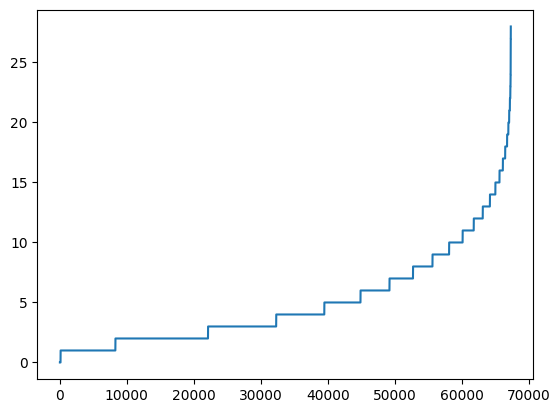

In [8]:
# network에 입력하려면, data의 크기(문장의 길이)는 동일해야함 -> padding
# 최대 단어 길이 : 28 -> 28을 기준으로 모든 vector를 28로 길이를 맞춰준다.
train_X_len = [len(x) for x in train_X]
train_X_len = sorted(train_X_len)

test_X_len = [len(x) for x in test_X]
test_X_len = sorted(test_X_len)

plt.plot(train_X_len)
plt.show()

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)
train_X = tokenizer.texts_to_sequences(train_X)
train_X = pad_sequences(train_X, maxlen = 28, padding = 'post')

test_X = tokenizer.texts_to_sequences(test_X)
test_X = pad_sequences(test_X, maxlen = 28, padding = 'post')

In [10]:
train_X.shape

train_X[0]

array([ 4112,    26, 11315,  6664,  4733,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0], dtype=int32)

In [11]:
train_y

array([0, 0, 1, ..., 1, 1, 0])

In [12]:
print("Padding Result : ", train_X.shape, test_X.shape)

Padding Result :  (67349, 28) (872, 28)


## Modeling Layers & Train

Reference
- https://github.com/Parkchanjun/KU-NLP-2020-1/blob/master/%5B4%5D%20Transformer%EB%A5%BC_%EC%9D%B4%EC%9A%A9%ED%95%9C_%EA%B0%90%EC%A0%95%EB%B6%84%EC%84%9D_%EC%98%81%EC%96%B4.ipynb

In [13]:
# == Multi Head Attention ==
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads #Multi-head Attention에서는 query, key, value를 바로 사용하는 것이 아닌 h번의 Linear projection을 따라 서로 다른 representation의 조합으로부터 Attention을 계산하는 방법이다.
        self.query_dense = layers.Dense(embed_dim) #쿼리
        self.key_dense = layers.Dense(embed_dim) #키
        self.value_dense = layers.Dense(embed_dim) #밸류
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True) #Q와 V를 곱한다.
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32) #텐서를 새로운 자료형으로 변환합니다.(tf.shape(key)[-1] = 차원)
        scaled_score = score / tf.math.sqrt(dim_key) #Sclae 작업, K차원의 루트값으로
        weights = tf.nn.softmax(scaled_score, axis=-1) #Softmax
        output = tf.matmul(weights, value) #V 곱하기
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim)) #Multihead Attention
        return tf.transpose(x, perm=[0, 2, 1, 3]) #x를 전치합니다. perm에 따라 차원의 순서를 구성합니다.

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0] #배치크기
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim) => tf.transpose(x, perm=[0, 2, 1, 3])의 결과
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value) #Self Attention
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

In [14]:
# == Transformer Layer ==
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs) #Multihead Attn 블록
        attn_output = self.dropout1(attn_output, training=training) #드롭아웃
        out1 = self.layernorm1(inputs + attn_output) #LM + Residual
        ffn_output = self.ffn(out1) #FF 블록
        ffn_output = self.dropout2(ffn_output, training=training) #드롭아웃
        return self.layernorm2(out1 + ffn_output) #LM + Residual

In [15]:
# == Embedding Layer ==
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, emded_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=emded_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=emded_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1) #포지션 정보
        positions = self.pos_emb(positions) #포지션 임베딩
        x = self.token_emb(x) #토큰임베딩
        return x + positions #합치기

In [22]:
# == 모델 구축 ==
maxlen = 28 # input sequence의 최대 길이
vocab_size = len(tokenizer.word_index) + 1 # 고유 단어의 개수(index를 붙임)

embed_dim = 28  # Embedding size for each token -> maxlen와 같아야함
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,)) #처음 입력
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim) #객체 생성
x = embedding_layer(inputs)  #포지셔널 임베딩

transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim) #객체 생성
x = transformer_block(x) #트랜스포머
x = layers.GlobalAveragePooling1D()(x) #Average Pooling
x = layers.Dropout(0.5)(x) #드롯아웃 -> Overfitting 방지
x = layers.Dense(20, activation="relu", kernel_regularizer=regularizers.l2(0.1))(x) # FFNN
x = layers.Dropout(0.5)(x) # 드롭아웃
outputs = layers.Dense(2, activation="softmax")(x) # Softmax

model = keras.Model(inputs=inputs, outputs=outputs) #모델 생성

In [23]:
# == 모델 학습 ==
# Dropout = 0.1 -> overfitting 났음 (epoch 5기준)
# Dropout = 0.5, L2 Regularization ->
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=2
                   )
optimizer = AdamW(learning_rate=1e-4, weight_decay =1e-4)

model.compile(optimizer = optimizer,
              loss = "sparse_categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(
    train_X, train_y, batch_size=256, epochs=30, validation_split = 0.2, callbacks = [es]
    )


Epoch 1/30
211/211 [==============================] - 4s 11ms/step - loss: 2.8956 - accuracy: 0.5093 - val_loss: 2.5846 - val_accuracy: 0.5598
Epoch 2/30
211/211 [==============================] - 3s 13ms/step - loss: 2.3863 - accuracy: 0.5680 - val_loss: 2.1705 - val_accuracy: 0.7175
Epoch 3/30
211/211 [==============================] - 3s 13ms/step - loss: 1.9940 - accuracy: 0.6502 - val_loss: 1.7796 - val_accuracy: 0.7817
Epoch 4/30
211/211 [==============================] - 2s 9ms/step - loss: 1.6315 - accuracy: 0.7387 - val_loss: 1.4135 - val_accuracy: 0.8439
Epoch 5/30
211/211 [==============================] - 2s 9ms/step - loss: 1.3022 - accuracy: 0.8217 - val_loss: 1.1142 - val_accuracy: 0.8673
Epoch 6/30
211/211 [==============================] - 2s 9ms/step - loss: 1.0404 - accuracy: 0.8729 - val_loss: 0.9091 - val_accuracy: 0.8800
Epoch 7/30
211/211 [==============================] - 2s 9ms/step - loss: 0.8412 - accuracy: 0.8999 - val_loss: 0.7691 - val_accuracy: 0.8826
Epo

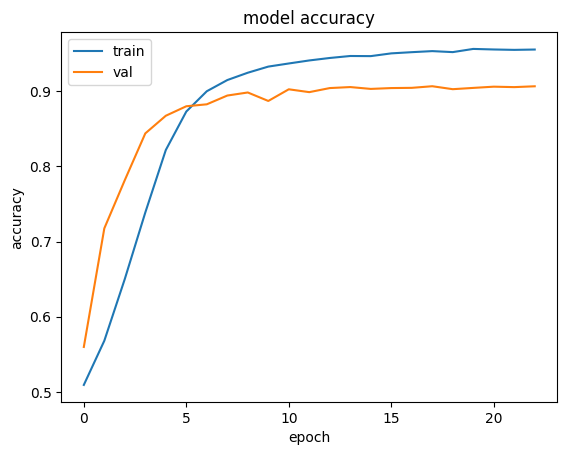

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('acc.png')
plt.show()

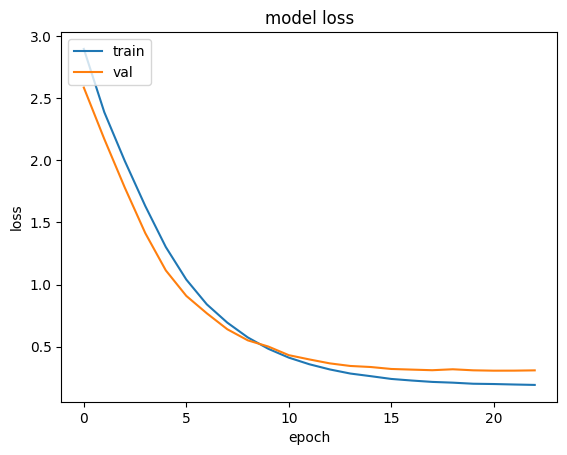

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss.png')
plt.show()

In [26]:
loss, accuracy = model.evaluate(test_X, test_y,
                                verbose = False)

print('Loss : {}'.format(loss))
print('Accuracy : {}'.format(accuracy))

Loss : 0.6683444976806641
Accuracy : 0.7832568883895874


In [27]:
y_pred_probs = model.predict(test_X)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(test_y, y_pred))

28/28 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.81      0.73      0.77       428
           1       0.76      0.84      0.80       444

    accuracy                           0.78       872
   macro avg       0.79      0.78      0.78       872
weighted avg       0.79      0.78      0.78       872

